# Homework 1: Computing and Data Analysis Review



*Your Name:*

## Learning Objectives

In this homework assignment, you will review and practice the following skills from CBE 20258:
* [Plotting in Python](https://ndcbe.github.io/data-and-computing/notebooks/01/Matplotlib.html) including [best practices](https://ndcbe.github.io/data-and-computing/notebooks/01/Publication-Quality-Figures.html)
* [Solving initial value problems in Python](https://ndcbe.github.io/data-and-computing/notebooks/07/Systems-of-Differential-Equations-and-Scipy.html)
* [Nonlinear regression](https://ndcbe.github.io/data-and-computing/notebooks/15/Nonlinear-Regression.html) with [weights based on measurement uncertainty](https://ndcbe.github.io/data-and-computing/notebooks/15/Weighted-Regression.html)
* [Error propagation](https://ndcbe.github.io/data-and-computing/notebooks/12/Error-Propagation.html) coupled with [nonlinear regression](https://ndcbe.github.io/data-and-computing/notebooks/15/Nonlinear-Case-Study-Adsorptive-Membranes.html)
* Solving a boundary value problem by calculating the [root of a nonlinear function](https://ndcbe.github.io/data-and-computing/notebooks/06/Newton-Methods-in-Scipy.html)

Each topic links to pages on a website with the CBE 20258 content. The search feature on the CBE 20258 is a great way to find more related examples.

## Deadlines

Because this is a long assignment and each exercise builds on the previous one, we are having two deadlines:
1. Homework 1A: Exercises 1, 2, and 3 are due (in their entirety) on **Tuesday, January 20 (10 PM)**.
2. Homework 1B: Exercises 4, 5, 6, and 7 are due (in their entirety) on **Tuesday, January 27 (10 PM)**. You will also submit Excercises 2 and 3 again. (In other words, do not delete these Exercises from your notebook.)

Shortly after the first deadline, we will post the solutions for Exercises 1, 2, and 3. You are expected to check these solutions and fix any mistakes. We are doing this because Exercises 4 and beyond require correct solutions for the earlier exercises.

## Introduction

This homework problem is inspired, in part, by a [Wired blog post](https://www.wired.com/2011/12/cannon-balls-size-matters/) analyzing an incident with a cannonball on the popular show Myth Busters.

Consider $n$ iron cannonballs of mass 12 lb (5.44 kg) fired at unknown angles $\theta_i$ (where $i \in \{1,...,n\}$) with unknown initial velocities $v_{0,i}$. The drag on the cannonball is $F_D = \frac{1}{2} \rho C_D A v |v|$ where $\rho$ is the density of air, $C_D$ is the coefficient of drag, and $A$ is the cross sectional area of the cannonball. We can lump these parameters together into a single unknown coefficient $\bar{C}_D$:

\begin{equation}
F_D = \bar{C}_D v |v|
\end{equation}

It is important to use $v |v|$ to account for the change in sign when the cannonball transitions from moving upward to moving downward.

Applying Newton's laws of motion gives the following coupled differential equations:

\begin{equation}
m \frac{dv_x}{dt}=-\bar{C}_D v_x |v |, \quad m \frac{dv_z}{dt} = -mg - \bar{C}_D v_z | v |,   \quad \frac{dx}{dt} = v_x, \quad \frac{dz}{dt} = v_z, \quad |v| = \sqrt{v_x^2 + v_z^2}
\end{equation}

We assume the cannonball is fired from the origin at time $t=0$ where $x$ and $z$ represent horiztonal and vertical displacement, respectively. This gives the follow initial values:

\begin{equation}
x(0) = 0, \quad z(0) = 0, \quad v_x(0) = v_0 \cos(\theta), \quad v_z(0) = v_0 \sin(\theta)
\end{equation}

The $n$ cannonballs are fired on completely flat terrian. We observe the impact location (horizonal distance traveled), impact time, and crater size. The latter can be correlated with impact velocity:

| Time (s) | Horizontal Displacement (m) | Impact Velocity (m/s) |
| -------- | --------------------------- | --------------------- |
| 12.0     | 726                         | 73                    |
| 6.8      | 529                         | 77                    |
| 15.3     | 616                         | 76                    |

Given these data, our ultimate goals are:
* Build a mathematical model
* Estimate $\theta_i$, $v_{0,i}$ and $\bar{C}_D$
* Predict the distance traveled and impact velocity of a cannonball shot at a new angle and initial velocity with uncertainty


We will assume the time, location, and velocity measurements are corrupted with normally distributed noise with a standard deviations of 0.2 s, 5 m, and 2 m/s, respectively. When we do regression, we need to account for the fact that the velocity estimates (based on crater size) have greater uncertainty.

## Exercise 1

On paper, derive the above ordinary differential equation model from first principles, similar to Physics I. Start with a free body diagram. Use trigonomety to justify the initial conditions.

## Exercise 2

Write a Python function to numerical simulate a cannon ball experiment. The inputs to your function should be the unknown parameters $\theta_i$, $v_{0,i}$, and $\bar{C}_D$. Your function should return:
1. Final time $t_f > 0$ when the cannonball returns to zero elevation, i.e., $z(t_f) = 0$
1. Horizontal distance traveled, $x(t_f)$
2. Impact velocity, $v(t_f) = \sqrt{v_x(t_f)^2 + v_z(t_f)^2}$

Hints:
* Use `solve_ivp` in `SciPy` instead of implementing your our numeric integration scheme. This will be more accurate. In the past, students who implemented their our numeric integration routine here had trouble with later exercises due to accuracy issues.
* The [SciPy docmentation](https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.integrate.solve_ivp.html) and [Num Stats examples](https://ndcbe.github.io/data-and-computing/notebooks/07/Systems-of-Differential-Equations-and-Scipy.html#scipy) are helpful.
* You can use the `events` optional argument in `solve_ivp` to find the time the cannonball returns to elevation 0. This [example shows how to use the `events` feature](https://ndcbe.github.io/controls/notebooks/2/One-Compartment-Pharmacokinetics.html).
* In the `SciPy` documentation for the `events` feature, look at the attributes `.terminal` and `.direction`. These are helpful.
* For a majority of students, spending 15 minutes to learn how to use the `events` feature is a lot less time then writing and debugging their own code to find the impact time, velocity, and distance.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
%matplotlib inline

def ode_rhs(t, y, Cd):
    """ODE system for a cannonball with drag
    Arguments:
        t: time (s)
        y: state vector [x, z, vx, vz] (m, m, m/s, m/s)
        Cd: drag coefficient (kg/m)

    Returns:
        dy: time derivative of the state vector [vx, vz, ax, az] (m/s, m/s, m/s^2, m/s^2)

    """

    x, z, vx, vz = y
    vabs = np.sqrt(vx**2 + vz**2)

    g = 9.81 # m/s^2
    m = 5.44 # kg

    ax = -Cd*vabs*vx/m
    az = -Cd*vabs*vz/m - g

    dy = [vx, vz, ax, az]
    return dy


def hits_ground(t, y, Cd):
  return y[1]
hits_ground.terminal = True
hits_ground.direction = -1

def simulate_experiment(Cd, angle, v0=100, tmax=200, plot=True, tdata=None, xdata=None, vdata=None):
    """Simulate an experiment.

    Arguments:
        Cd: drag coefficient (kg/m)
        angle: launch angle (degrees)
        v0: initial speed (m/s)
        tmax: maximum time (s)
        plot: bool, if true, plot simulation results and data
        tdata: measured impact time (s) [only used for plotting]
        xdata: measured impact location (m) [only used for plotting]
        vdata: inferred impect velocity (m/s) [only used for plotting]

    Returns:
        tfinal: final time (s)
        xfinal: final x position (m)
        vfinal: final speed (m/s)

    """
    y = [0, 0, v0*np.cos(np.deg2rad(angle)), v0*np.sin(np.deg2rad(angle))]
    y0 = y
    soln = integrate.solve_ivp(ode_rhs, (0, tmax), y0, events=hits_ground, args=(Cd,), max_step=0.1)
    tfinal = soln.t[-1]
    xfinal = soln.y[0][-1]
    vfinal = np.sqrt(soln.y[2][-1]**2 + soln.y[3][-1]**2)

    plt.plot(soln.y[0], soln.y[1], label='Simulation')
    if plot:
        plt.scatter(xdata, vdata, label='Data')
        plt.xlabel('Horizontal Displacement (m)')
        plt.ylabel('Vertical Displacement (m)')
        plt.legend()
        plt.show()
    return tfinal, xfinal, vfinal


## Exercise 3

Test your function by simulating the provided data for the cannonball experiments. For each experiment, make a plot showing the model predictions (lines) and observed data (symbols). You can use the data given below as intial guesses for $\theta_{i}$ and $v_{0,i}$. You can use $\bar{C_D} = 0.003$ as an intial guess for the coefficient of drag.

In [15]:
import pandas as pd

data = {}
data['time'] = [12.0, 6.9, 15.3]
data['distance'] = [726., 529., 616.]
data['velocity'] = [73., 77., 76.]
data['theta_guess'] = [40., 20., 60.]
data['v0_guess'] = [110., 100., 90.]
df = pd.DataFrame(data)
df.head()

,time,distance,velocity,theta_guess,v0_guess
0,12.0,726.0,73.0,40.0,110.0
1,6.9,529.0,77.0,20.0,100.0
2,15.3,616.0,76.0,60.0,90.0


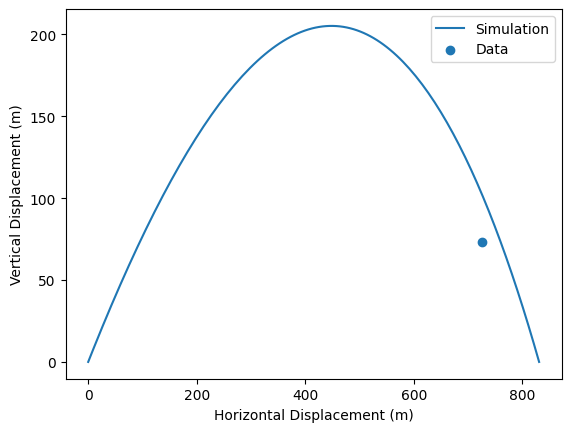

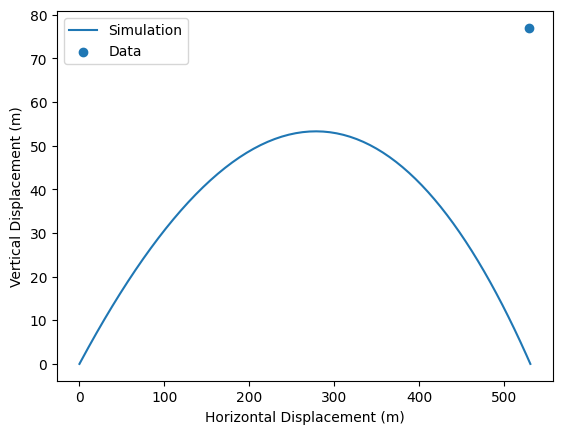

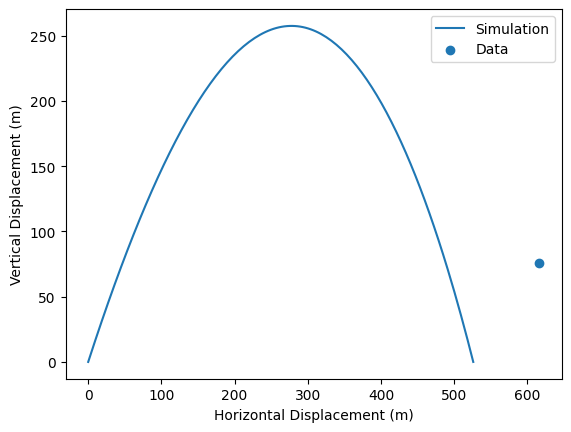

In [20]:
# Confirm your plots show both the simulation results (lines)
# and experimental data (symbols)
for i, row in df.iterrows():
    simulate_experiment(0.003,
                        row.theta_guess,
                        xdata=row.distance,
                        vdata=row.velocity,
                        tdata=row.time,
                        v0=row.v0_guess,
                        plot=True)



## Exercise 4

Perform nonlinear regression to estimate $\bar{C}_D$, $\theta_1$, ..., $\theta_n$, $v_{0,1}$, ..., $v_{0,n}$. Report the estimate parameters with a reasonable number of significant digits. Include plots to compare the model predictions and experiment data.

In [ ]:
from scipy.optimize import least_squares

def unpack(param):
    """ Unpacks the vector "param"

    Arguments:
        param: vector [Cd, theta1, theta2, ..., thetaN, v01, v02, ..., v0N]

    Returns,
        Cd: lumped drag coefficient (kg/m)
        theta: launch angles (degrees)
        v0: initial speeds (m/s)

    """
    n = (len(param) - 1 )//2
    Cd = param[0]
    theta = param[1:(n+1)]
    v0 = param[(n+1):(2*n+1)]
    return Cd, theta, v0

def pack(Cd, theta, v0):
    """ Packs the parameters into a vector

    Arguments:
        Cd: lumped drag coefficient (kg/m)
        theta: launch angles (degrees)
        v0: initial speeds (m/s)

    Returns:
        param: vector [Cd, theta1, theta2, ..., thetaN, v01, v02, ..., v0N]
    """
    return np.hstack([Cd, theta, v0])

# Assumed standard deviation of measurement error
sigma_t = 0.2 # s
sigma_x = 5 # m
sigma_v = 2 # m/s

def residuals_all(parameter_vec, data, plot=False):
    """
    Computes the residuals for all experiments

    Arguments:
        parameter_vec: vector [Cd, theta1, theta2, ..., thetaN, v01, v02, ..., v0N]
        data: dataframe with experimental data
        plot: bool, if true, plot simulation results and data

    Returns:
        residuals: vector of residuals scaled by the measurement uncertainty
    """

    n = len(data)

    Cd, theta, v0 = unpack(parameter_vec)

    # Allocate matrix for residuals, n experiments (rows) with 3 measurements per experiment (columns)
    residuals = np.zeros((n,3))

    # Loop over experiments
    for i, row in data.iterrows():
        # Simulate experiment
        tsim, xsim, vsim = simulate_experiment(Cd,
                        theta[i],
                        v0 = v0[i],
                        xdata=row.distance,
                        vdata=row.velocity,
                        tdata=row.time,
                        plot=plot)

        # Compute and record scaled residuals
        residuals[i,0] = (tsim - row.time)/sigma_t
        residuals[i,1] = (xsim - row.distance)/sigma_x
        residuals[i,2] = (vsim - row.velocity)/sigma_v

    # Flatten the residual matrix into a vector
    return residuals.reshape(3*n)


# Define initial guess
initial_vector = pack([0.003], df.theta_guess.to_numpy(), df.v0_guess.to_numpy())

# Evaluate residuals at initial guess
print(residuals_all(initial_vector,df,plot=False))


In [ ]:
# Perform nonlinear regression

# Add your solution here

# Determine the number of experiments
n = len(df)

# Extract the estimated parameters
Cd_est = sln.x[0]
theta_est = sln.x[1:(n+1)]
v0_est = sln.x[(n+1):(2*n+1)]

# Print the results (with rounding and units)
print("Cd =",round(Cd_est,4)," kg/m")
for i in range(0,n):
    print("\nExperiment",i+1)
    print("theta =",round(theta_est[i],1),"degrees")
    print("v0 =",round(v0_est[i],1),"m/s")


# Plot the experimental data and the simulation results
residuals_all(sln.x, df, True)

## Exercise 5

Quantify the uncertainty in your parameter estimates. *Hint:* Calculate the covariance matrix and correlation matrix of the estimated parameters.

In [ ]:
# Add your solution here

In [ ]:
# Add your solution here

In [ ]:
# Add your solution here

In [ ]:
# Add your solution here

In [ ]:
# Add your solution here

Interpret your uncertianty estimate in a few sentences.

*Answer*:

In a few sentences, describe and justify your choice of uncertainty quantification method. In other words, what are the pros and cons of the selected method and why it is a reasonable choice for this problem.

*Answer*:

## Exercise 6

Determine the firing angle $\theta_j$ and intial velocity $v_{0,j}$ to hit a target at 300 m with an impact velocity of 80 m/s.

In [ ]:


from scipy.optimize import fsolve

def firing_residuals(guess):
    """ Residuals for the firing experiment

    Arguments:
        guess: vector [angle in deg, v0 in m/s]

    Returns:
        residuals: vector [position, impact speed]


    """

    # Add your solution here

## Exercise 7

Quantify and interpret the uncertainty in your prediction (distance, time, velocity) from the previous exercise. Assume you can specify the firing angle and initial velocity with uncertainties of 1 degree and 2 m/s, respectively. You also have some uncertainty in your estimate of $C_D$ (quantified above).

Hints:
* Calculate the covariance matrix and correlation matrix for the predicted displacement and impact velocity.
* You learned two ways to perform uncertainty propagation in Num Stats: first-order error propagation and Monte Carlo. Both approaches, when properly implemented, are suitable for this task.
* Start by writing some pseudocode. If you are performing first-order error propagation, write on paper the governing equation. Then work out the dimensions of all of the matrices. Likewise, for Monte Carlo error propagation, write pseudocode with all of the logical steps. If you need help with this Exercise, expect the TAs and Instructor(s) to ask to see you pseudocode.
* Be sure you are considering uncertainty in all three inputs: $C_D$ (Exercise 6), $v_{0}$ (problem statement), and $\theta$ (problem statement).

In [ ]:
# Add your solution here

# Here is code copied from CBE 20258 notebooks that you may find helpful
# You can also answer this question without calculating a Jacobian
def Jacobian(f,x,delta = 1.0e-7):
    '''Approximate Jacobian using forward finite difference

    Args:
        f: vector-valued function
        x: point to build approximation J(x) around
        delta: finite difference step size

    Returns:
        J: m x n Jacobian matrix (approximation), where
            n = length of x
            m = length of f(x)

    Reference:
        https://ndcbe.github.io/data-and-computing/notebooks/06/Newton-Raphson-Methods-for-Systems-of-Equations.html

    '''


    #Evaluate function f at x
    fx = f(x) #only need to evaluate this once

    # Determine size
    N = x.size
    M = fx.size

    # Allocate empty matrix
    J = np.zeros((M,N))

    idelta = 1.0/delta #division is slower than multiplication
    x_perturbed = x.copy() #copy x to add delta

    # Loop over elements of x and columns of J
    for i in range(N):
        # Perturb (apply step) to element i of x
        x_perturbed[i] += delta

        # Approximate column in Jacobian
        col = (f(x_perturbed) - fx) * idelta

        # Reset element of x
        x_perturbed[i] = x[i]

        # Save results
        J[:,i] = col
    # end for loop
    return J

# Add your solution here

Please interpret the uncertainty in your predictions. How do these results compare to the measurement uncertainty?

*Answer*:

## Submission Instructions

Please submit your answer to Exercise 1, neatly written on paper, to Gradescope as a PDF. Please submit your answers to the remaining exercises in this notebook (.ipynb file) to Gradescope. There are two separate assignments on Gradescope.

## Declarations

**Collaboration**: If you worked with any classmates, please give their names here. Describe the nature of the collaboration.

**Generative AI**: If you used any Generative AI tools, please elaborate here.